## Ridge Regression Multi-Output Baseline
 - 70/15/15 - Train, Validation and Test Splits
 - Prints metrics for Train/Val/Test

     1) R² bars - comparing the performance between Train and Validation (light blue)
     2) Scatter grid - Test split
     3) Residual histograms 
     4) Mean |coef| (Ridge) on standardized features (light blue)

[INFO] Using 107919 rows
[INFO] Train time: 0.182s

=== Train ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9147 1.1761e-09 8.9180e-10
voltage_rise_time_pulse2 0.6275 2.7007e-09 1.3897e-09
voltage_fall_time_pulse1 0.9824 9.0433e-10 6.8701e-10
voltage_fall_time_pulse2 0.9824 9.0327e-10 6.8611e-10
current_rise_time_pulse1 0.8851 1.5994e-08 1.0679e-08
current_rise_time_pulse2 0.7822 1.2403e-08 9.6649e-09
current_fall_time_pulse1 0.9633 2.4584e-09 1.8738e-09
current_fall_time_pulse2 0.9629 2.4705e-09 1.8869e-09
       overshoot_pulse_1 0.8410 5.3695e+00 3.9913e+00
       overshoot_pulse_2 0.8292 1.1026e+01 8.4365e+00
      undershoot_pulse_1 0.8779 4.7448e+00 3.2630e+00
      undershoot_pulse_2 0.8796 4.7084e+00 3.2597e+00
   ringing_frequency_MHz 0.9949 2.2975e+00 1.6132e+00
R2_avg          0.8864
RMSE_avg    3.9258e+00
MAE_avg     1.5818e+00
dtype: object
Predict Time (ms/sample): 0.0011

=== Validation ===
                  Target     R2       RMSE

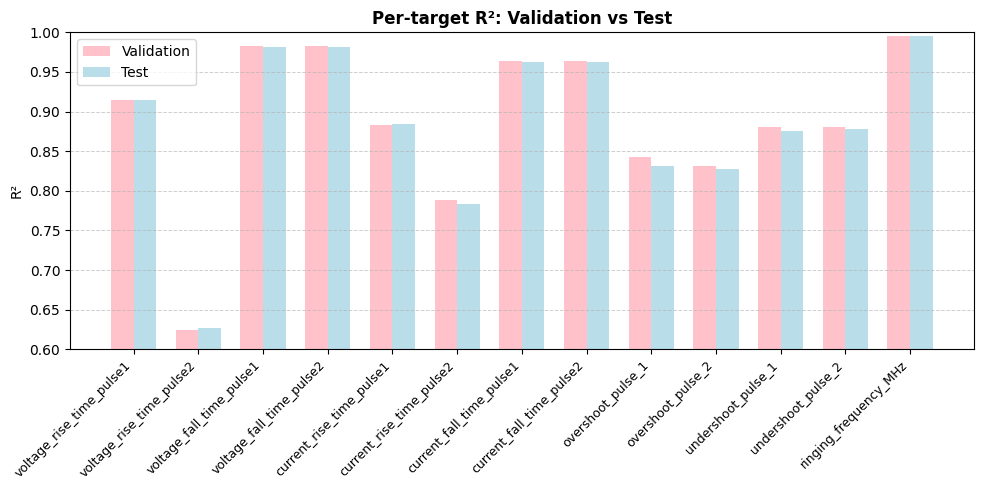

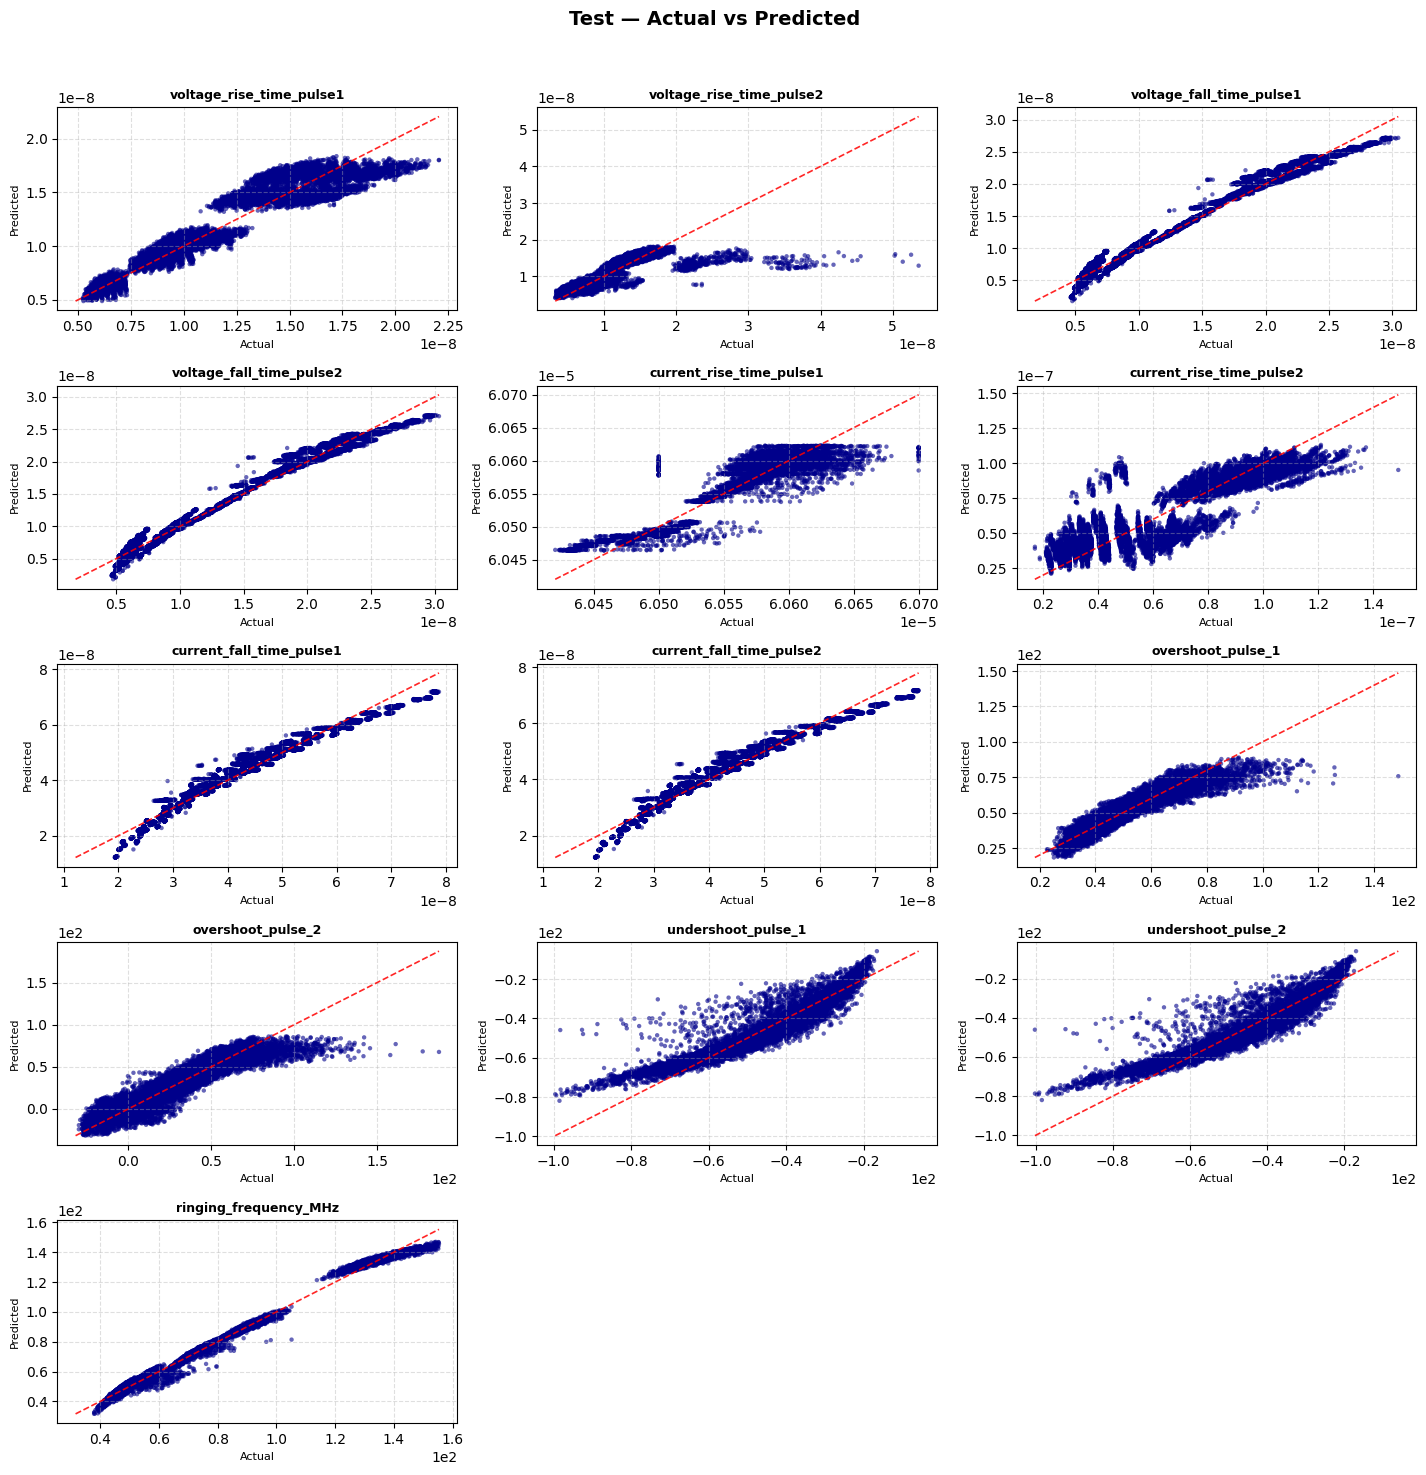

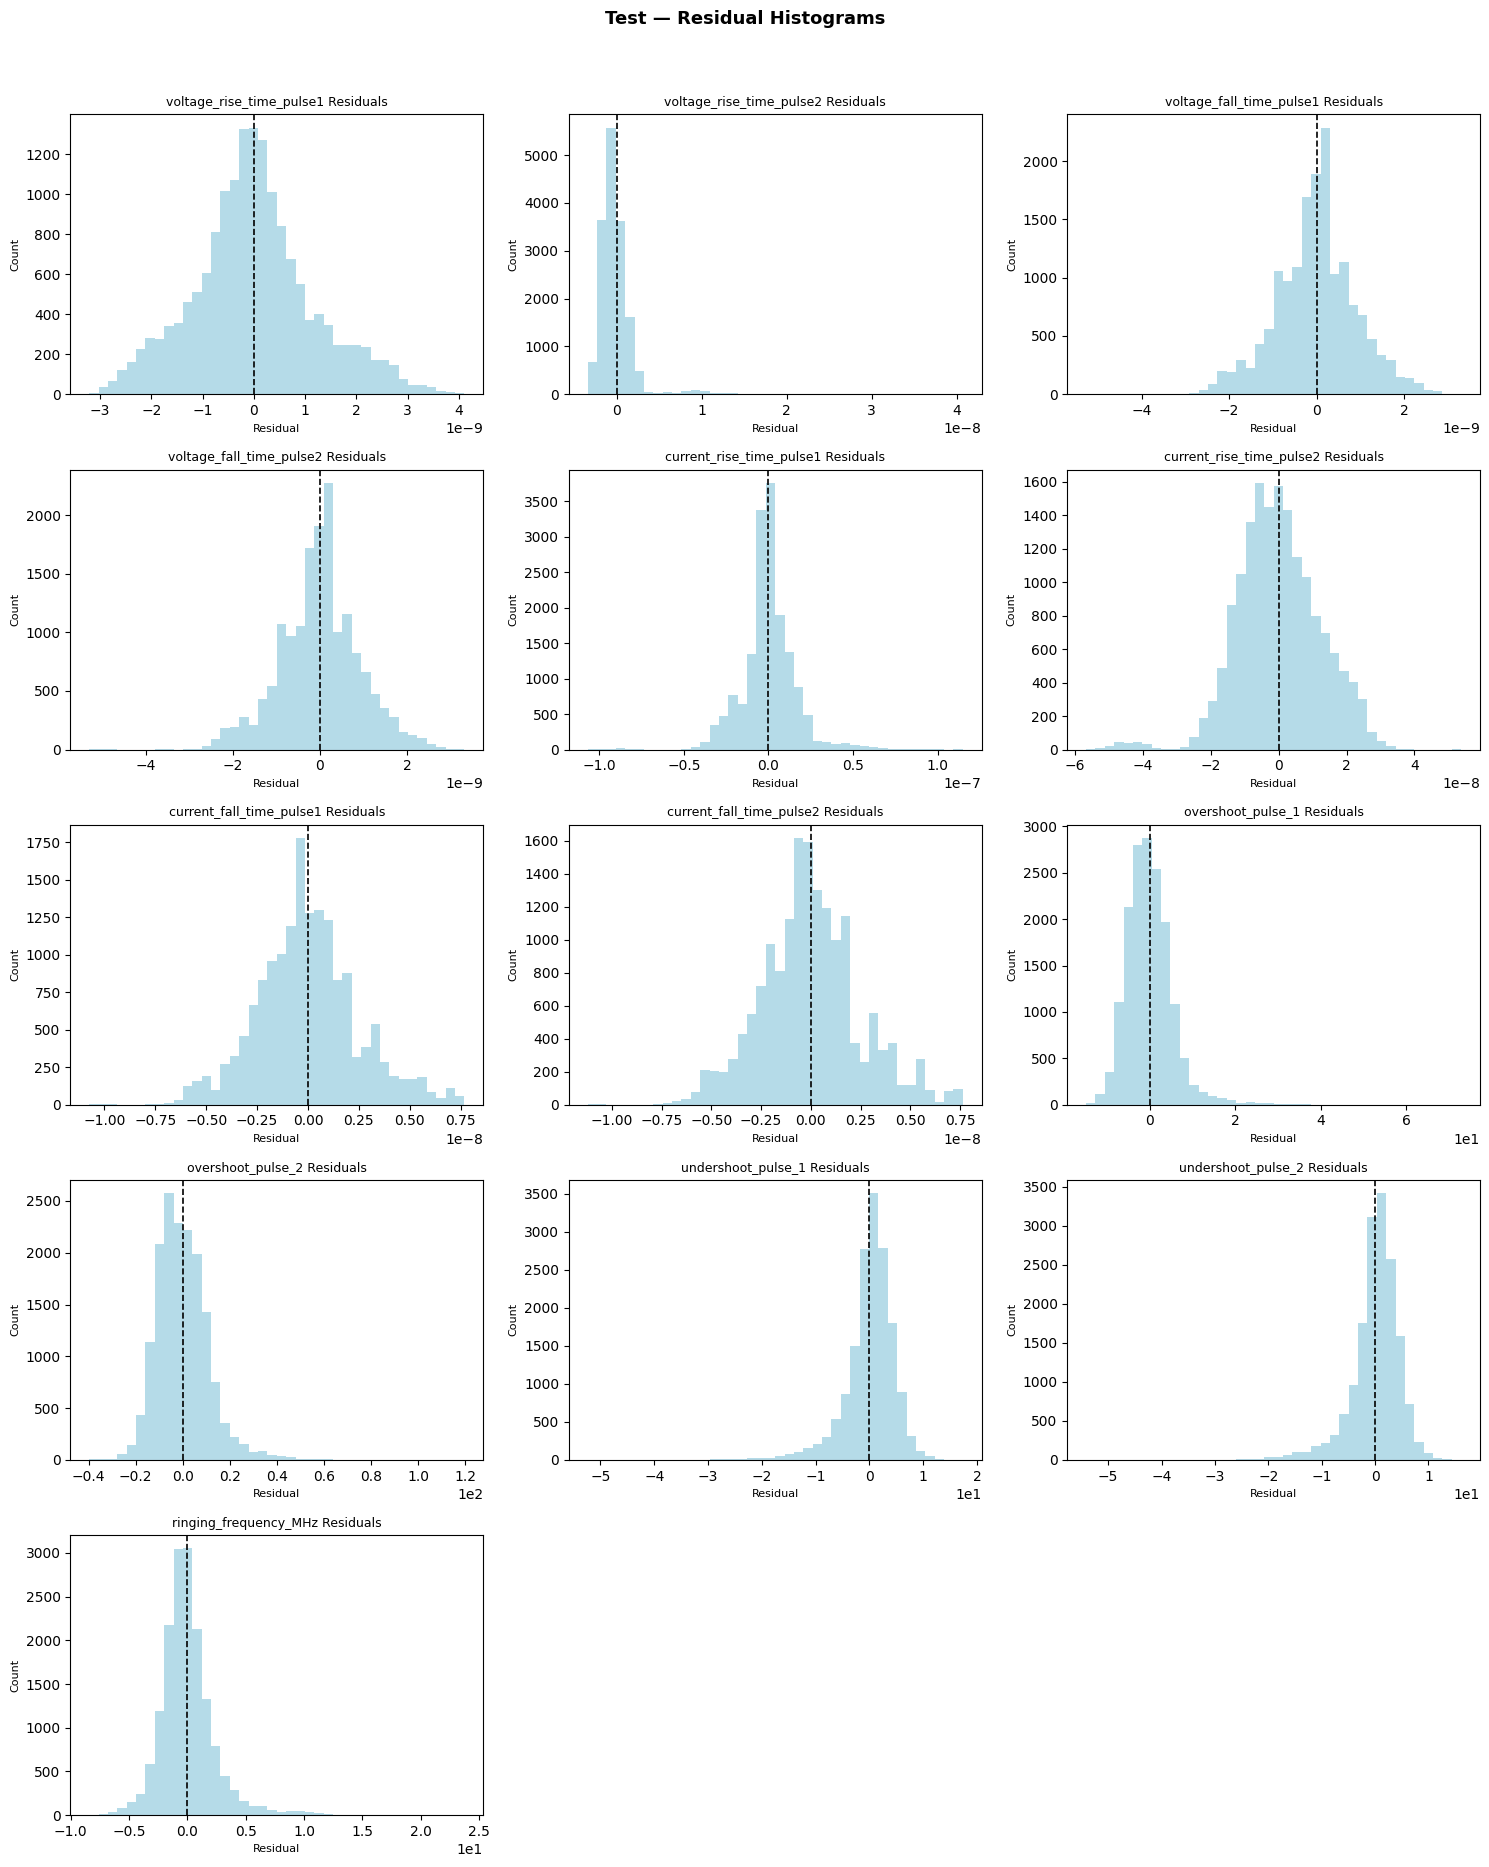

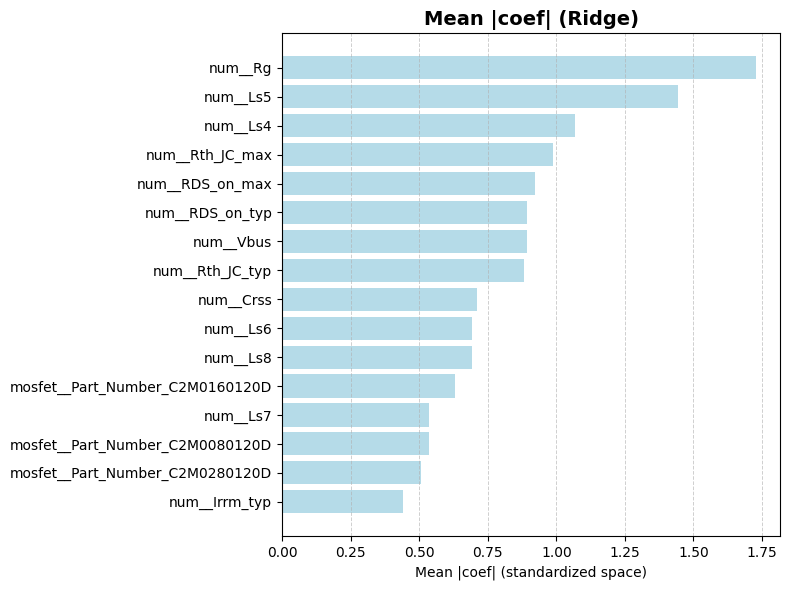

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# =========================
# CONFIGURATION
# =========================
# Path to dataset
DATA_FILE   = r"C:\Users\pc\Desktop\THESIS_DISTINCTION_THRISHA_RAJKUMAR\merged_train_5_MOSFETs.csv"

# Speed settings
FAST_MODE   = True          # If True, subsample the dataset for faster testing
FAST_FRAC   = 0.25          # Fraction to keep when FAST_MODE is on
SEED        = 42            # Random seed for reproducibility

# Plotting / reporting settings
GRID_COLS   = 3             # Number of columns in scatter/residual grids
TOP_K_COEF  = 16            # Number of top features to show in coefficient bar plot

# 13 EMI targets (outputs) to be predicted
TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]

# Column(s) representing the MOSFET identity (categorical feature)
MOSFET_COLS = ['Part_Number']


# =========================
# UTILITY FUNCTIONS
# =========================

def make_ohe():
    """
    Create a version-safe OneHotEncoder.
    - In scikit-learn >= 1.4, 'sparse_output' is used.
    - In older versions, 'sparse' must be set instead.
    """
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def build_pipeline(num_cols, mosfet_cols, alpha=1.0, seed=SEED):
    """
    Build a preprocessing + model pipeline.
    Steps:
    1. Preprocessing:
       - Standardize numeric features (zero mean, unit variance).
       - One-hot encode MOSFET identity column(s).
    2. Ridge Regression model (multi-output by default).
    """
    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("mosfet", make_ohe(), mosfet_cols),
        ],
        remainder="drop",
    )
    return Pipeline([
        ("preprocessor", pre),
        ("regressor", Ridge(alpha=alpha, random_state=seed)),
    ])


def get_feature_names(preprocessor, num_names, mosfet_names):
    """
    Recover feature names after preprocessing:
    - Numeric features keep their names with 'num__' prefix.
    - MOSFET columns expand into multiple one-hot encoded columns.
    """
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        names = [f"num__{n}" for n in num_names]
        try:
            ohe = preprocessor.named_transformers_["mosfet"]
            for col, levels in zip(mosfet_names, ohe.categories_):
                names += [f"mosfet__{col}={lvl}" for lvl in levels]
        except Exception:
            names += [f"mosfet__{c}_<onehot>" for c in mosfet_names]
        return np.array(names, dtype=object)


def per_target_metrics(y_true, y_pred, targets):
    """
    Compute performance metrics per target and overall:
    - R² : variance explained (closer to 1 = better fit).
    - RMSE: root mean squared error (physical units).
    - MAE : mean absolute error (physical units).
    Returns:
        dfm: per-target DataFrame of metrics
        overall: dict of averaged/global metrics
    """
    rows = []
    for i, t in enumerate(targets):
        yt, yp = y_true[:, i], y_pred[:, i]
        rows.append([
            t,
            r2_score(yt, yp),
            np.sqrt(mean_squared_error(yt, yp)),
            mean_absolute_error(yt, yp),
        ])
    dfm = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg":   r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg":  mean_absolute_error(y_true, y_pred),
    }
    return dfm, overall


def evaluate_split(name, model, X, y, targets):
    """
    Evaluate the model on a given dataset split.
    Steps:
    - Predict values.
    - Compute latency per sample.
    - Compute metrics (per target + overall).
    - Pretty print a summary table.
    Returns:
        dfm: per-target metrics DataFrame
        overall: overall metrics dict
        y_pred: predictions array
    """
    t0 = time.time()
    y_pred = model.predict(X)
    ms = (time.time() - t0) / max(1, len(X)) * 1000.0  # ms/sample

    dfm, overall = per_target_metrics(y, y_pred, targets)

    # Pretty print
    dfp = dfm.copy()
    dfp["R2"]   = dfp["R2"].map(lambda x: f"{x:.4f}")
    dfp["RMSE"] = dfp["RMSE"].map(lambda x: f"{x:.4e}")
    dfp["MAE"]  = dfp["MAE"].map(lambda x: f"{x:.4e}")

    print(f"\n=== {name} ===")
    print(dfp.to_string(index=False))
    print(pd.Series({
        "R2_avg":   f"{overall['R2_avg']:.4f}",
        "RMSE_avg": f"{overall['RMSE_avg']:.4e}",
        "MAE_avg":  f"{overall['MAE_avg']:.4e}",
    }))
    print(f"Predict Time (ms/sample): {ms:.4f}")
    return dfm, overall, y_pred


# =========================
# PLOTTING FUNCTIONS
# =========================

def plot_val_vs_test_r2(val_df, test_df):
    """
    Compare R² scores for Validation vs Test sets.
    - Each bar = one target.
    - Useful for spotting generalization gaps.
    """
    targets = test_df["Target"].tolist()
    x = np.arange(len(targets))
    width = 0.35
    fig, ax = plt.subplots(figsize=(max(10, 0.6*len(targets)), 5))
    ax.bar(x - width/2, val_df["R2"].values,  width, label="Validation", color="#ffb6c1", alpha=0.85)
    ax.bar(x + width/2, test_df["R2"].values, width, label="Test",       color="#add8e6", alpha=0.85)
    ax.set_xticks(x); ax.set_xticklabels(targets, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("R²"); ax.set_title("Per-target R²: Validation vs Test", weight="bold")
    ax.set_ylim(0.6, 1.0); ax.grid(axis="y", linestyle="--", alpha=0.6, linewidth=0.7)
    ax.legend(); plt.tight_layout(); plt.show()


def plot_test_scatter_grid(y_true, y_pred, targets, n_cols=GRID_COLS):
    """
    Actual vs Predicted scatter plots for each target.
    - Blue dots = predictions.
    - Red dashed line = perfect fit (y=x).
    - Curvature or spread indicates systematic bias.
    """
    n_targets = len(targets)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 3.0*n_rows))
    axes = axes.flatten()
    for i, t in enumerate(targets):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.6, color="darkblue", edgecolors="none")
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], "--", lw=1.2, color="red", alpha=0.85)
        ax.set_title(t, fontsize=9, weight="bold"); ax.grid(True, linestyle="--", alpha=0.4)
        ax.ticklabel_format(style="sci", axis="both", scilimits=(0,0))
        ax.set_xlabel("Actual", fontsize=8); ax.set_ylabel("Predicted", fontsize=8)
    for j in range(i+1, len(axes)): axes[j].axis("off")
    plt.suptitle("Test — Actual vs Predicted", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


def plot_test_residual_histograms(y_true, y_pred, targets, n_cols=GRID_COLS):
    """
    Histogram of residuals (error = true - pred) per target.
    - Symmetry around zero = unbiased.
    - Skew or heavy tails = systematic bias or outliers.
    """
    residuals = y_true - y_pred
    n_targets = len(targets)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.8*n_rows))
    axes = axes.flatten()
    for i, t in enumerate(targets):
        ax = axes[i]
        ax.hist(residuals[:, i], bins=40, color="#add8e6", alpha=0.9)
        ax.axvline(0, color="black", linestyle="--", linewidth=1.2)
        ax.set_title(f"{t} Residuals", fontsize=9)
        ax.set_xlabel("Residual", fontsize=8); ax.set_ylabel("Count", fontsize=8)
        ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
    for j in range(i+1, len(axes)): axes[j].axis("off")
    plt.suptitle("Test — Residual Histograms", fontsize=13, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


def plot_mean_abs_coef_ridge(pipeline, num_names, mosfet_names, top_k=TOP_K_COEF):
    """
    Plot the mean absolute value of coefficients across all outputs.
    - Features are in standardized space (so magnitudes are comparable).
    - Top features indicate which inputs have the strongest *linear* influence.
    """
    pre = pipeline.named_steps["preprocessor"]
    reg = pipeline.named_steps["regressor"]
    feat_names = get_feature_names(pre, num_names, mosfet_names)

    coefs = np.abs(reg.coef_)       # (n_targets, n_features_transformed)
    mean_abs = coefs.mean(axis=0)   # average across outputs

    top = (pd.DataFrame({"feature": feat_names, "mean_abs_coef": mean_abs})
             .sort_values("mean_abs_coef", ascending=False)
             .head(top_k).iloc[::-1])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(top["feature"], top["mean_abs_coef"], color="#add8e6", alpha=0.9)
    ax.set_title("Mean |coef| (Ridge)", fontsize=14, weight="bold")
    ax.set_xlabel("Mean |coef| (standardized space)"); ax.set_ylabel("")
    ax.grid(axis="x", linestyle="--", alpha=0.6, linewidth=0.7)
    plt.tight_layout(); plt.show()


# =========================
# MAIN WORKFLOW
# =========================
def main():
    # 1. Load dataset
    df = pd.read_csv(DATA_FILE).dropna(subset=TARGETS).reset_index(drop=True)
    if FAST_MODE:
        df = df.sample(frac=FAST_FRAC, random_state=SEED).reset_index(drop=True)
    print(f"[INFO] Using {len(df)} rows")

    # 2. Split into features (X) and targets (y)
    X = df.drop(columns=TARGETS)
    y = df[TARGETS].values
    num_cols = [c for c in X.columns if c not in MOSFET_COLS]

    # 3. Build model pipeline (preprocessing + Ridge)
    model = build_pipeline(num_cols, MOSFET_COLS, alpha=1.0, seed=SEED)

    # 4. Train/val/test split: 70/15/15
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, random_state=SEED, shuffle=True)
    X_va, X_te,  y_va, y_te  = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED, shuffle=True)

    # 5. Train the Ridge model
    t0 = time.time()
    model.fit(X_tr, y_tr)
    print(f"[INFO] Train time: {time.time() - t0:.3f}s")

    # 6. Evaluate on all splits
    tr_df, tr_over, _   = evaluate_split("Train",      model, X_tr, y_tr, TARGETS)
    va_df, va_over, _   = evaluate_split("Validation", model, X_va, y_va, TARGETS)
    te_df, te_over, y_p = evaluate_split("Test",       model, X_te, y_te, TARGETS)

    # 7. Diagnostic plots on TEST set
    plot_val_vs_test_r2(va_df, te_df)
    plot_test_scatter_grid(y_te, y_p, TARGETS, n_cols=GRID_COLS)
    plot_test_residual_histograms(y_te, y_p, TARGETS, n_cols=GRID_COLS)
    plot_mean_abs_coef_ridge(model, num_cols, MOSFET_COLS, top_k=TOP_K_COEF)


if __name__ == "__main__":
    main()
